In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
from datetime import date, timedelta
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax.random import PRNGKey

import mechafil.data as mecha_data
import mechafil.sim as np_sim
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting
import mechafil_jax.plot_utils as pu
import mechafil_jax.date_utils as du

import scenario_generator.utils as u
import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc

from cel_utils import disk_utils

In [4]:
save_dir = '/Users/kiran/Documents/filp_saturation'
offline_info_dir = os.path.join(save_dir, 'offline_info')
os.makedirs(save_dir, exist_ok=True)
os.makedirs(offline_info_dir, exist_ok=True)

In [21]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

current_date = date(2023,7,28) - timedelta(days=3)
start_date = date(current_date.year, current_date.month, 1)
forecast_length = 365*10
end_date = current_date + timedelta(days=forecast_length)

offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

print(start_date, current_date, end_date)

2023-07-01 2023-07-25 2033-07-22


In [22]:
t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=365*2), current_date)
t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=365*2), current_date)
t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=365*2), current_date)

smooth_historical_rr = np.median(hist_rr[-30:])

In [26]:
smooth_historical_rr

0.7170058601946124

In [23]:
lock_target = 0.3
sector_duration = 540

rbp_vec = [5, 10, 15, 20, 25]
filp_vec = [0.5, 0.75, 1.0]

results_dict = {}
for rbp_val in rbp_vec:
    for filp_val in filp_vec:
        # run simulation
        rbp = jnp.ones(forecast_length) * rbp_val
        rr = jnp.ones(forecast_length) * smooth_historical_rr
        fpr = jnp.ones(forecast_length) * filp_val

        simulation_results = sim.run_sim(
            rbp,
            rr,
            fpr,
            lock_target,

            start_date,
            current_date,
            forecast_length,
            sector_duration,
            offline_data
        )
        results_dict[(rbp_val, filp_val)] = simulation_results
    

In [24]:
t = du.get_t(start_date, end_date=end_date)

<IPython.core.display.Javascript object>


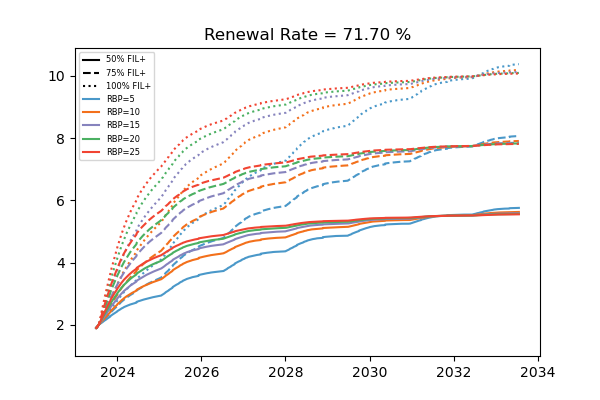

Text(0.5, 1.0, 'Renewal Rate = 71.70 %')

In [29]:
colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Purples'], mpl.colormaps['Greens'], mpl.colormaps['Reds']]
linestyles = ['-', '--', ':']
cmap_access_vec = np.linspace(0.2, 0.8, len(filp_vec))

plt.figure(figsize=(6,4))

for ii, rbp_val in enumerate(rbp_vec):
    for jj, filp_val in enumerate(filp_vec):
        r = results_dict[(rbp_val, filp_val)]
        plt.plot(t, r['network_QAP_EIB']/r['network_RBP_EIB'], color=colors[ii](0.6), linestyle=linestyles[jj])

plt.plot(t[0],0, color='k', linestyle='-', label='50% FIL+')
plt.plot(t[0],0, color='k', linestyle='--', label='75% FIL+')
plt.plot(t[0],0, color='k', linestyle=':', label='100% FIL+')
plt.plot(t[0],0, color=colors[0](0.6), label='RBP=%d' % (rbp_vec[0],))
plt.plot(t[0],0, color=colors[1](0.6), label='RBP=%d' % (rbp_vec[1],))
plt.plot(t[0],0, color=colors[2](0.6), label='RBP=%d' % (rbp_vec[2],))
plt.plot(t[0],0, color=colors[3](0.6), label='RBP=%d' % (rbp_vec[3],))
plt.plot(t[0],0, color=colors[4](0.6), label='RBP=%d' % (rbp_vec[4],))

plt.ylim(1)
plt.legend(fontsize=6)
plt.title('Renewal Rate = %0.02f %%' % (smooth_historical_rr*100, ))